# Exploratory Data Analysis – Credit Card Transactions

**Dataset:** creditcard.csv  
**Objective:**  
Initial inspection of anonymized bank transaction data to understand structure,
class imbalance, and feature distributions.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

credit_df = pd.read_csv("../data/raw/creditcard.csv")


In [2]:
credit_df.info()

credit_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

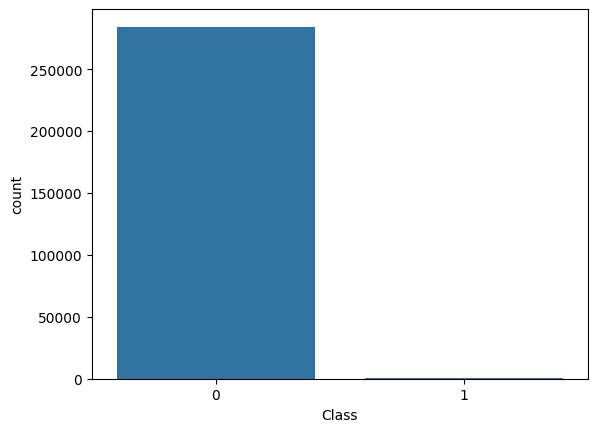

In [3]:
credit_df["Class"].value_counts(normalize=True) * 100

sns.countplot(x="Class", data=credit_df)
plt.show()

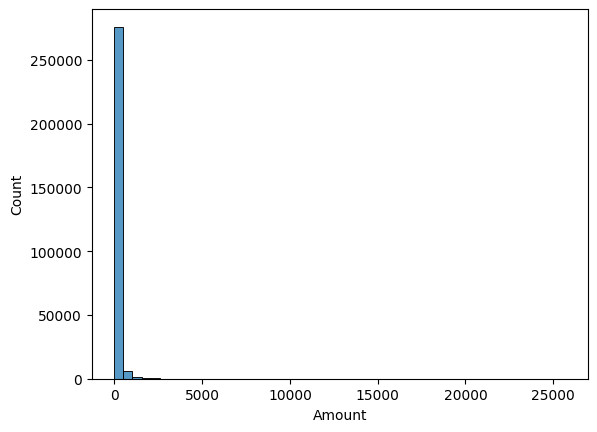

In [4]:
sns.histplot(credit_df["Amount"], bins=50)
plt.show()


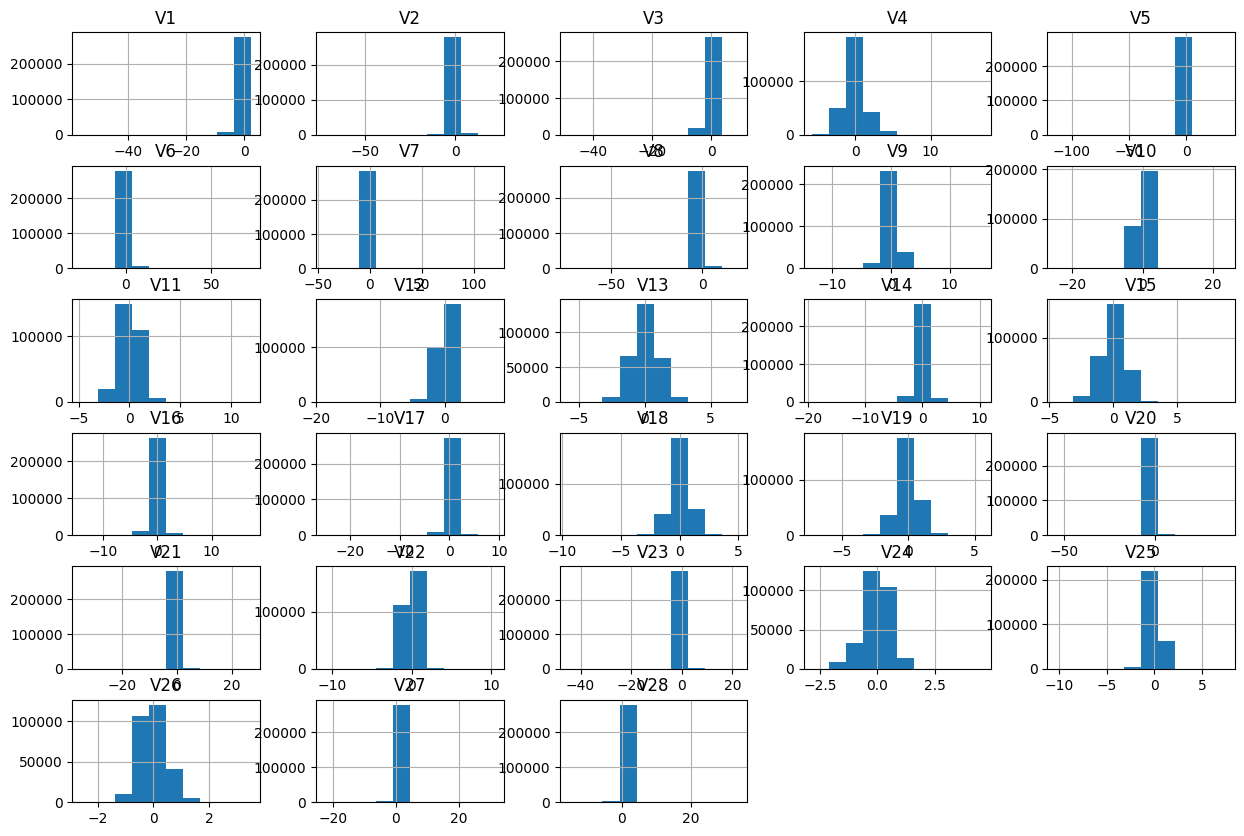

In [5]:
credit_df.iloc[:, 1:29].hist(figsize=(15, 10))
plt.show()


In [ ]:
credit_df.to_csv("../data/processed/creditcard_processed.csv", index=False)
